In [1]:
import os
os.environ["PYARROW_IGNORE_EXTENSION_TYPES"] = "1"
import pandas as pd


In [2]:
pd.__version__

'2.3.1'

In [6]:
#df = pd.read_parquet('../yellow_tripdata_2024-01.parquet', engine="fastparquet")
df = pd.read_parquet('../yellow_tripdata_2024-01.parquet')

In [4]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2.0,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186.0,79.0,2.0,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1.0,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140.0,236.0,1.0,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1.0,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236.0,79.0,1.0,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1.0,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79.0,211.0,1.0,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1.0,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211.0,148.0,1.0,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [2]:
import sklearn

In [6]:
sklearn.__version__

'1.7.0'

In [3]:
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_absolute_percentage_error



In [7]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_absolute_percentage_error(y_train, y_pred)

0.6721879805727156

/tmp/ipykernel_9738/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_9738/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


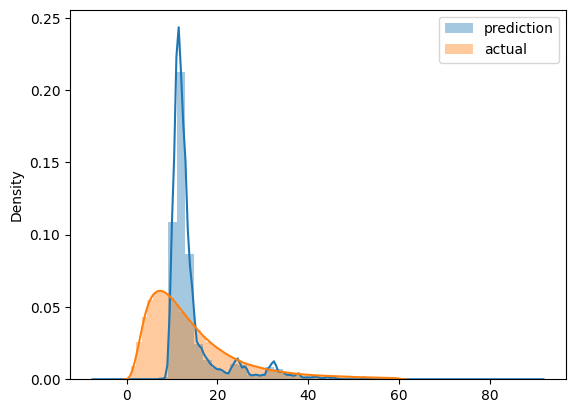

In [11]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [3]:


def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df



In [4]:
df_train = read_dataframe('../yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('../yellow_tripdata_2023-02.parquet')

In [11]:
len(df_train), len(df_val)

(3009173, 2855951)

In [5]:


df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']



In [6]:

from sklearn.feature_extraction import DictVectorizer

categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
#X_val = dv.transform(val_dicts)



In [7]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [9]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

#y_pred = lr.predict(X_val)

#mean_absolute_percentage_error(y_val, y_pred)

LinearRegression()